# Quantum Time Evolution

The aim here is to employ use of a high-fidelity solver in order to approximate the time-dependent Schrodinger equation. We will again start by focusing on the Harmonic Oscillator, then move on to studying non-linear cases, specifically the Gross-Pitaevski equation. Once we're successfully able to establish a high-accuracy numerical solution in both cases, our plan is explore how different machine learning methods may help us reduce compuation time without sacrificing accuracy.

Lets start by importing the libraries we'll be using for the high fidelity solver.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

Next, lets define some functions that will allow us to preform our time propogation.

Firstly, we'll construct the hamiltonian of the harmonic oscillator. We know the hamiltonian of the harmonic oscillator is equal to the following:

$$ \hat{H} =  \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2\hat{x}^2$$

Where p-hat is the momentum operator, x-hat is the position operator, m is the mass of our particle, and omega represents the angular velocity.

We know the following about the momentum operator:

$$ \hat{p} = i\hbar\frac{\partial}{\partial x} $$

This allows us to rewrite our hamiltonian with respect only to position space, like so:

$$ \hat{H} =  \frac{-\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{1}{2}m\omega^2\hat{x}^2$$

We can represent this hamiltonian as a square matrix, where each the number of elements each row/column is equal to the inverse of our spacial steps (dx). Using finite difference methods, we can approximate the second derivative in this expression. Let us set this up using numpy. Note, q represents omega in the function below.

In [2]:
def construct_hamiltonian(N, x, dx, h_bar, mass, q):
    potential =  (mass * x**2 * q**2)/2
    potential = np.diag(potential)

    hamiltonian = np.zeros((N, N))#,dtype=np.complex128)
    
    finite_diff = -2 * np.eye(N)
    finite_diff += np.eye(N, k=1)
    finite_diff += np.eye(N, k=-1)
    
    kinetic = -h_bar**2 / (2 * mass) * (finite_diff/dx**2)
    
    hamiltonian = kinetic + potential

    return hamiltonian

It would also be useful to define an function that acts as our time evolution operator, generally given by:

$$ e^{\frac{i\hat{H}t}{\hbar}} $$

Unfortunately, this operator is not of much use to us in this form. In order to be mathematically compatible with the hamiltonian matrix we defined earlier, we have to preform a taylor series expansion of this exponential.

FINISH EXPANSION


In [3]:
def taylor_series_expansion(matrix, terms, t):
    n = matrix.shape[0]
    identity = np.eye(n, dtype=np.complex128)
    result = identity.copy()
    matrix_power = matrix.copy()

    # Expand time evolution operator e^(-itH)
    for i in range(1, terms + 1):
        term = (matrix_power**i) * (t**i) * (-1j**i) / np.math.factorial(i)
        result += term

    return result

Now that both of those functions are established, lets start visualizing some solutions.

In order to solve for our actual wavefunction, lets consider the following relation:

$$ \hat{H} \ket{\psi} = E \ket{\psi}$$


REWORK THIS

Where E is a states eigenvalue and psi is the wavefunction (also known as the eigenfunction). To solve this eigensystem, its acceptable to use either numpy or scipys built-in solver (use eig for numpy, eigh for scipy). Its worth noting here that the results will vary slightly depending on which library is used. The numpy solution seems to have an extra factor of -1 present in the eigenfunction, which can be easily corrected with an additional factor. I'm not certain the reason for this, and would like to spend time analyzing the inner workings of both of these functions. However, for now we'll simply use the scipy version to avoid unnecessary factors. Its likely I'll explore at a later time this outside of this notebook.

So with the above in mind, we can start by setting some constants and a domain. We can then plug these into our hamiltonian function and solve for the eigensystem. In this notebook, we'll be primarily focused on the ground state, but note that there techncially exists an infinite number of excited states. To check if our hamiltonian was generated correctly, we'll graph eigenvectors of the ground state to visualize the wavefunction. Take care to seperate the real and imaginary parts when graphing. This will become important once we start propagating through time!

[[ 632.51       -310.005         0.         ...    0.
     0.            0.        ]
 [-310.005       632.31000323 -310.005      ...    0.
     0.            0.        ]
 [   0.         -310.005       632.11161933 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  632.11161933
  -310.005         0.        ]
 [   0.            0.            0.         ... -310.005
   632.31000323 -310.005     ]
 [   0.            0.            0.         ...    0.
  -310.005       632.51      ]]


Text(0, 0.5, 'Wavefunction')

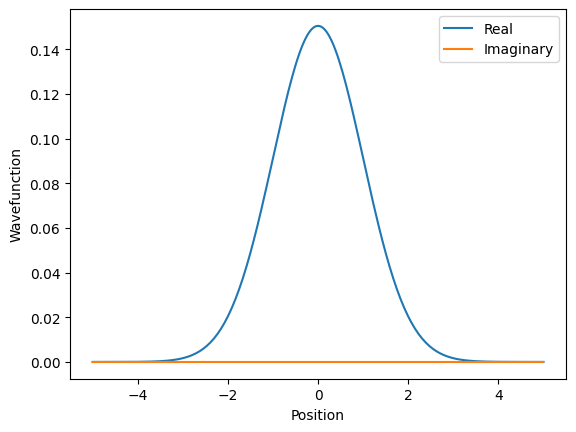

In [4]:
h_bar = 1#.05457e-35
mass = 1
q = 1
N = 250

x = np.linspace(-5, 5, N)
dx = x[1] - x[0]

H = construct_hamiltonian(N, x, dx, h_bar, mass, q)
print(H)

# Differences between sp and np?
#eigenvalues, eigenvectors = np.linalg.eigh(H)
eigenvalues, eigenvectors = sp.linalg.eigh(H)
initial_state = eigenvectors.copy()

plt.plot(x, np.real(initial_state[:,0]))
plt.plot(x, np.imag(initial_state[:,0]))
plt.legend(["Real","Imaginary"])
plt.xlabel("Position")
plt.ylabel("Wavefunction")

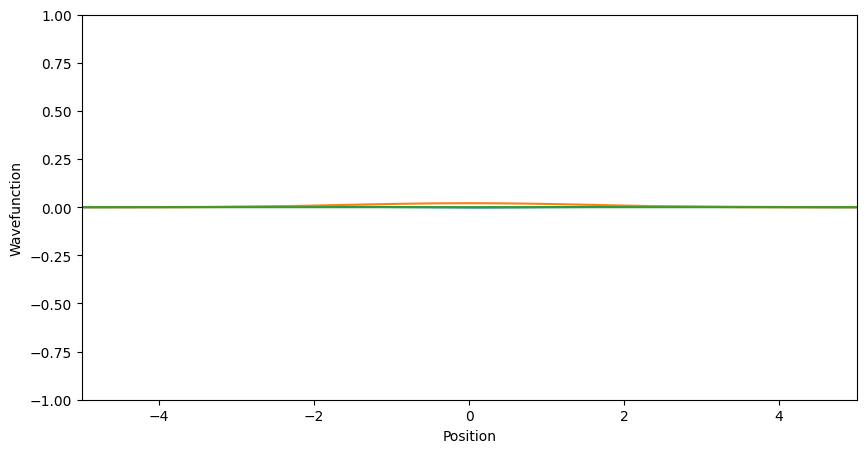

<Figure size 1000x500 with 0 Axes>

In [5]:
t = 0
t_max = 1
t_steps = 250
t_values = np.linspace(t, t_max, t_steps)
dt = t_values[1] - t_values[0]
count = 0
terms = 3

fig, ax = plt.subplots(figsize=(10, 5))

while t <= t_max:

    if t == 0:
        final_state = initial_state.copy()
        final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
        #final_state = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)

        #norm = final_state / np.linalg.norm(prob_density)*dx
    
    else:

        teo = taylor_series_expansion(H, terms, dt)
        new_state = np.dot(teo, final_state_norm)
        final_state = final_state.astype(np.complex128)
        final_state = new_state.copy()
        final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
        #final_state = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)

        #prob_density = np.abs(final_state)**2
        #norm = final_state /(np.linalg.norm(prob_density))*dx

    #pd = np.sqrt(np.dot(final_state, np.conj(final_state))*dx)
    pd = np.real(final_state_norm*np.conj(final_state_norm))
    #pd = np.abs(final_state_norm)**2

    plt.plot(x, (np.imag(final_state_norm[:,0])))
    plt.plot(x, (np.real(final_state_norm[:,0])))
    plt.plot(x, pd[:,0])
    plt.xlim([-5,5])
    plt.ylim([-1,1])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

    t += dt
    count += 1

KeyboardInterrupt: 

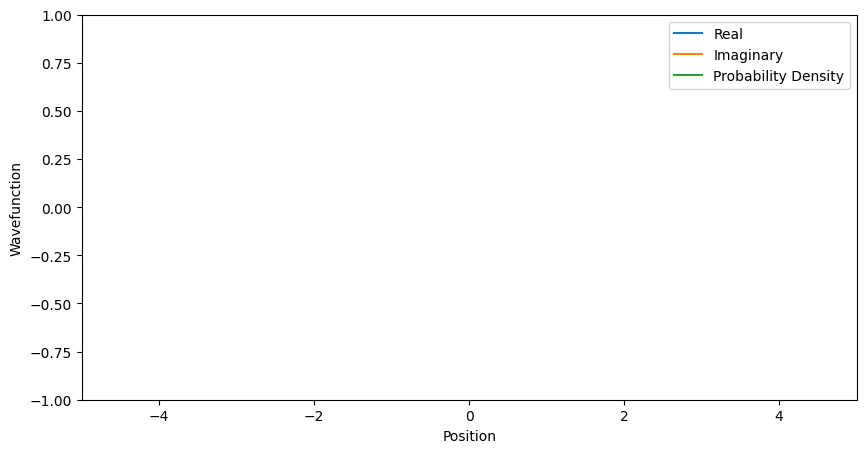

In [26]:
t = 0
t_max = 1
count = 0

fig, ax = plt.subplots(figsize=(10, 5))

while t <= t_max:

    if t == 0:
        final_state = initial_state.copy()
        final_state = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)
    
    else:

        teo = taylor_series_expansion(H, terms,  dt)
        new_state = np.dot(teo, final_state)
        final_state = final_state.astype(np.complex128)
        final_state = new_state.copy()
        final_state = final_state/np.sqrt(np.dot(final_state,np.conj(final_state)))

    plt.plot(x, eigenvalues[0]+(np.real(final_state[:,0])))
    plt.plot(x, eigenvalues[0]+(np.imag(final_state[:,0])))
    plt.plot(x, np.abs(final_state[:,0])**2)
    plt.legend(['Real','Imaginary','Probability Density'])
    plt.xlim([-5,5])
    plt.ylim([-1,1])
    #plt.plot(x, eigenvalues[0]+final_state[:,0])
    #plt.xlim([-5,5])
    #plt.ylim([-0,1])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

    t += dt
    count += 1

In [37]:
def run_simulation(Nx, Nt, terms):
    
    h_bar = 1
    mass = 1
    q = 1

    x = np.linspace(-5, 5, Nx)
    dx = x[1] - x[0]
    t = 0
    t_max = 1
    t_values = np.linspace(t, t_max, Nt)
    dt = t_values[1] - t_values[0]
    count = 0

    time_start = time.time()

    H = construct_hamiltonian(Nx, x, dx, h_bar, mass, q)
    eigenvalues, eigenvectors = sp.linalg.eigh(H)
    initial_state = eigenvectors.copy()
    #all_states = np.zeros((Nt, Nx, Nx), dtype=complex)

    while t <= t_max:
            
        #H = construct_hamiltonian(Nx, x, dx, h_bar, mass, q)
        #eigenvalues, eigenvectors = sp.linalg.eigh(H)
        initial_state = eigenvectors.copy()

        if t == 0:
            final_state = initial_state.copy()
            final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
            #all_states[count] = final_state

        else:

            teo = taylor_series_expansion(H, terms,  dt)
            new_state = np.dot(teo, final_state)
            final_state = final_state.astype(np.complex128)
            final_state = new_state.copy()
            final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
            #all_states[count] = final_state

        t += dt
        count += 1

    time_finish = time.time()
    time_diff = time_finish - time_start
    
    return initial_state, final_state, final_state_norm, time_diff#all_states, time_diff


In [50]:
HF_initial, HF_final, HF_final_norm, HF_time = run_simulation(500, 1000, 3)

C:\Users\kozy8\AppData\Local\Temp\ipykernel_21440\892795932.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term = (matrix_power**i) * (t**i) * (-1j**i) / np.math.factorial(i)
C:\Users\kozy8\AppData\Local\Temp\ipykernel_21440\1329247458.py:39: RuntimeWarning: invalid value encountered in divide
  final_state_norm = final_state/(np.linalg.norm(final_state)*dx)


In [49]:
print(HF_final)

[[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 ...
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]


In [41]:
dx = [50, 100, 150, 200, 250]
dt = [50, 100, 250, 500, 1000]
terms = [2, 3, 4, 5, 6, 7]

#test_is, testfs, testt = run_simulation(dx[3], dt[2], terms[3])
#print(testt)

times = []
All_states = []
for i in range(len(dx)):
    for j in range(len(terms)):
        i_state, f_state, timer = run_simulation(dx[i], dt[2], terms[j])
        times.append([dx[i], terms[j], timer])
        #All_states.append(a_states)
print(times)

dx_values = []
term_values = []
time_values = []

for i in range(len(times)):
    dx_values.append(times[i][0])
    term_values.append(times[i][1])
    time_values.append(times[i][2])
print(time_values)

C:\Users\kozy8\AppData\Local\Temp\ipykernel_5616\4254880222.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term = (matrix_power**i) * (t**i) * (-1j**i) / np.math.factorial(i)


[[50, 2, 0.08265924453735352], [50, 3, 0.055481910705566406], [50, 4, 0.061398983001708984], [50, 5, 0.07003211975097656], [50, 6, 0.09880995750427246], [50, 7, 0.0842139720916748], [100, 2, 0.09989309310913086], [100, 3, 0.14329028129577637], [100, 4, 0.1828000545501709], [100, 5, 0.19061708450317383], [100, 6, 0.21862053871154785], [100, 7, 0.23444628715515137], [150, 2, 0.2366640567779541], [150, 3, 0.2707505226135254], [150, 4, 0.3291187286376953], [150, 5, 0.34325337409973145], [150, 6, 0.4632680416107178], [150, 7, 0.45191502571105957], [200, 2, 0.48310041427612305], [200, 3, 0.6954793930053711], [200, 4, 0.7794106006622314], [200, 5, 1.0546915531158447], [200, 6, 1.1575353145599365], [200, 7, 1.296184778213501], [250, 2, 1.1654009819030762], [250, 3, 1.192291021347046], [250, 4, 1.3437912464141846], [250, 5, 1.5722923278808594], [250, 6, 1.61875319480896], [250, 7, 1.8713865280151367]]
[0.08265924453735352, 0.055481910705566406, 0.061398983001708984, 0.07003211975097656, 0.09880

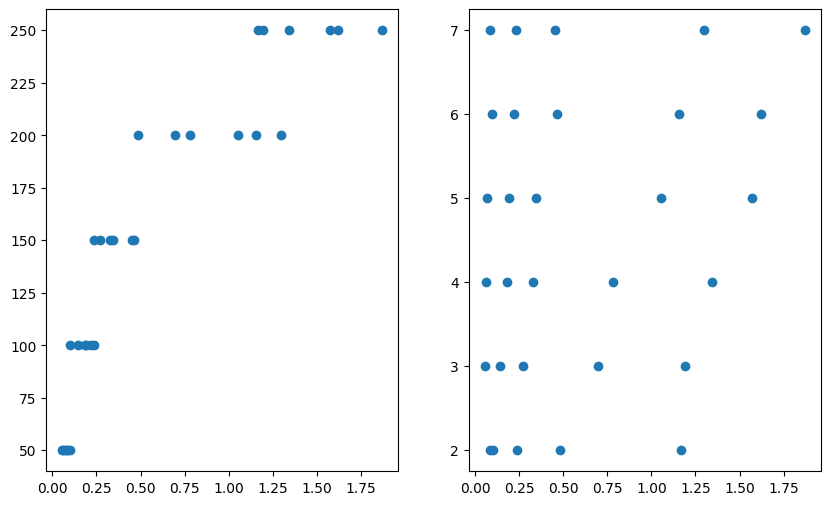

In [42]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.scatter(time_values, dx_values)
plt.xlabel()
plt.subplot(122)
plt.scatter(time_values, term_values)

In [40]:
def run_simulation_save(Nx, Nt, terms):
    
    h_bar = 1
    mass = 1
    q = 1

    x = np.linspace(-5, 5, Nx)
    dx = x[1] - x[0]
    t = 0
    t_max = 1
    t_values = np.linspace(t, t_max, Nt)
    dt = t_values[1] - t_values[0]
    count = 0

    time_start = time.time()

    H = construct_hamiltonian(Nx, x, dx, h_bar, mass, q)

    eigenvalues, eigenvectors = sp.linalg.eigh(H)
    initial_state = eigenvectors.copy()
    all_states = np.zeros((Nt, Nx, Nx), dtype=complex)

    while t <= t_max:

        if t == 0:
            final_state = initial_state.copy()
            final_state = final_state/np.linalg.norm(final_state)
            all_states[count] = final_state

        else:

            teo = taylor_series_expansion(H, terms,  dt)
            new_state = np.dot(teo, final_state)
            final_state = final_state.astype(np.complex128)
            final_state = new_state.copy()
            final_state = final_state/np.linalg.norm(final_state)
            all_states[count] = final_state

        t += dt
        count += 1

    time_finish = time.time()
    time_diff = time_finish - time_start
    
    return initial_state, final_state, all_states, time_diff

In [29]:
i_state2, f_state2, a_states2, timer2 = run_simulation_save(500,5000,7)

C:\Users\kozy8\AppData\Local\Temp\ipykernel_21580\4254880222.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term = (matrix_power**i) * (t**i) * (-1j**i) / np.math.factorial(i)


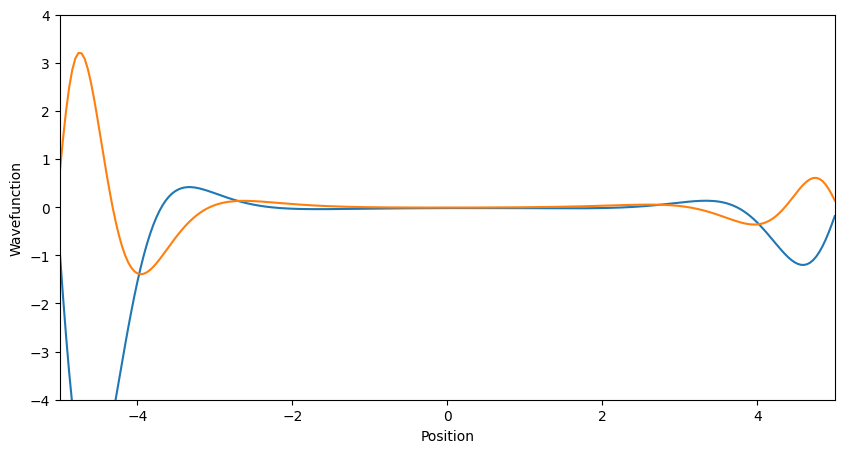

<Figure size 1000x500 with 0 Axes>

In [8]:
h_bar = 1#.05457e-35
mass = 1
q = 1
N = 250

x = np.linspace(-5, 5, N)
dx = x[1] - x[0]

initial_state = np.exp(-(x+0.2)**2 / 2.0) / np.sqrt(np.pi+2)

t = 0
t_max = 3
t_steps = 600
t_values = np.linspace(t, t_max, t_steps)
dt = t_values[1] - t_values[0]
count = 0
terms = 3

fig, ax = plt.subplots(figsize=(10, 5))

while t <= t_max:

    if t == 0:
        final_state = initial_state.copy()
        final_state = final_state/(np.linalg.norm(final_state)*dx)
    
    else:

        teo = taylor_series_expansion(H, terms, dt)
        new_state = np.dot(teo, final_state)
        #print(new_state)
        final_state = final_state.astype(np.complex128)
        final_state = new_state.copy()
        final_state = final_state/(np.linalg.norm(final_state)*dx)

    pd = np.abs(final_state)**2
    plt.plot(x, (np.imag(final_state[:])))
    plt.plot(x, (np.real(final_state[:])))
    #plt.plot(x, pd[:])
    plt.xlim([-5,5])
    plt.ylim([-4,4])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

    t += dt
    count += 1

Sources:

https://dr.ascsn.net/HO_Time/HO_Time_Dependent.html

https://en.wikipedia.org/wiki/Finite_difference_coefficient

https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator